In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#train_file = "/content/drive/MyDrive/FYP/datasetAG.zip"
train_file = "/content/drive/MyDrive/FYP/dataset.zip"

import zipfile

with zipfile.ZipFile(train_file, 'r') as z:
    z.extractall()

In [ ]:
from tensorflow.keras import optimizers
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
import numpy as np
import os

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #rotation_range=10,
        #width_shift_range=0.1,
        #height_shift_range=0.1,
        ##brightness_range=[0.4,0.7],
        ##channel_shift_range=60.0,
        #fill_mode='nearest',
        #horizontal_flip=True
        )

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical')  # more than two classes

validation_generator = validation_datagen.flow_from_directory(
        'dataset/validation',
        target_size=(224, 224),
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical',
        shuffle = False
)

Found 903 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [ ]:
### RETRIVE TEST LABEL FROM GENERATOR ###

train_num = train_generator.samples

label_train = []
train_images = []
for i in range((train_num // train_generator.batch_size)+1):
    X,y = train_generator.next()
    label_train.append(y)
    train_images.append(X)
        
label_train = np.argmax(np.vstack(label_train), axis=1)
train_images = np.vstack(train_images)
train_images = np.array(train_images)
label_train = np.array(label_train)
label_train.shape

(903,)

In [ ]:
train_images.shape

(903, 224, 224, 3)

In [ ]:
### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = validation_generator.samples

label_test = []
test_images = []
for i in range((test_num // validation_generator.batch_size)+1):
    X,y = validation_generator.next()
    label_test.append(y)
    test_images.append(X)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
test_images = np.vstack(test_images)
test_images = np.array(test_images)
label_test = np.array(label_test)
label_test.shape

(150,)

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(label_test)
test_labels_encoded = le.transform(label_test)
le.fit(label_train)
train_labels_encoded = le.transform(label_train)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0


In [ ]:
from keras.applications.vgg16 import VGG16

VGG_model = VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

VGG_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
print("This is the number of trainable weights before freezing the conv base:", len(VGG_model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
VGG_model.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(VGG_model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
VGG_model.trainable = True

set_trainable = False
for layer in VGG_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#extract features using VGG imagenet weights
#Train features
train_feature_extractor=VGG_model.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)
#test features
test_feature_extractor=VGG_model.predict(x_test)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

In [ ]:
############################################################
#RANDOM FOREST implementation 
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 150, random_state = 42)

In [ ]:
# Train the model on training data
RF_model.fit(train_features, y_train) 

RandomForestClassifier(n_estimators=150, random_state=42)

In [ ]:
prediction_RF = RF_model.predict(test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)
#Print overall accuracy
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,mean_absolute_error,log_loss
print ("Accuracy = ", metrics.accuracy_score(label_test, prediction_RF))
print ("Loss : ",mean_absolute_error(label_test, prediction_RF))

Accuracy =  0.6866666666666666
Loss :  0.35333333333333333


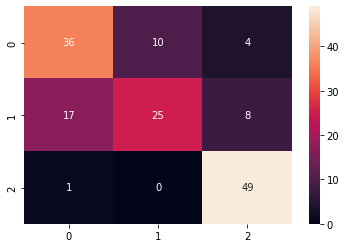

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix, classification_report,mean_absolute_error,log_loss
import seaborn as sns
cm = confusion_matrix(label_test, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
# View the classification report for test data and predictions
print (classification_report(label_test, prediction_RF))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        50
           1       0.71      0.50      0.59        50
           2       0.80      0.98      0.88        50

    accuracy                           0.73       150
   macro avg       0.73      0.73      0.72       150
weighted avg       0.73      0.73      0.72       150



-----------------

KNN 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(train_features , y_train)

KNeighborsClassifier()

In [ ]:
prediction_KNN = knn.predict(test_features)
#Inverse le transform to get original label back. 
prediction_KNN = le.inverse_transform(prediction_KNN)
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(label_test, prediction_KNN))
print ("Loss : ",mean_absolute_error(label_test, prediction_KNN))

Accuracy =  0.7933333333333333
Loss :  0.23333333333333334


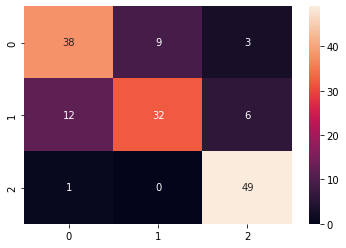

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(label_test, prediction_KNN)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
# View the classification report for test data and predictions
print(classification_report(label_test, prediction_KNN))

              precision    recall  f1-score   support

           0       0.75      0.76      0.75        50
           1       0.78      0.64      0.70        50
           2       0.84      0.98      0.91        50

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.79       150
weighted avg       0.79      0.79      0.79       150

